# ВНИМАНИЕ!!!
ПОСЛЕ ПЕРВОЙ ЯЧЕЙКИ КОДА НЕОБХОДИМО ПЕРЕЗАГРУЗИТЬ СРЕДУ ВЫПОЛНЕНИЯ. ДАЛЕЕ ВСЕ ЯЧЕЙКИ МОЖНО БУДЕТ ВЫПОЛНИТЬ АВТОМАТИЧЕСКИ

In [ ]:
!pip install --upgrade --force-reinstall numpy gensim

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp

In [ ]:
pip install huggingface_hub[hf_xet]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 33.6 MB/s eta 0:00:00


In [ ]:
import os
import re
import copy
import random
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from tqdm import tqdm

import cv2
import gensim
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch.nn.utils.rnn import pad_sequence

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0

import albumentations as A
from albumentations.pytorch import ToTensorV2

from transformers import BertTokenizer, BertModel

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
!pip install natasha
from natasha import MorphVocab, Doc, Segmenter, NewsEmbedding, NewsMorphTagger

morph_vocab = MorphVocab()
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def lemmatize_text(text):
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    return ' '.join([t.lemma for t in doc.tokens])


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('russian'))

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 133.5 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=a042bbceb446a24f0f507a00f19613aecaae194e8ceed538302484835f44fe18
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26098 sha256=7399a832106cbe5753a289597797bc5e16b5fce74540ff40ca8e31e8b8f9b66c
  Stored in directory: /root/.cache/pip/wheels/31/d7/d9/eec6891f78cac19a693bd40ecb8365d2f4613318c145ec9816
Successfully built docopt intervaltree


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"antonlite","key":"50a7f3d218c35d64952eb1fe7007b19b"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dl-2025-study-competition-2
!unzip dl-2025-study-competition-2.zip

  0% 0.00/12.9M [00:00<?, ?B/s]
100% 12.9M/12.9M [00:00<00:00, 1.21GB/s]
Archive:  dl-2025-study-competition-2.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


1) Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, сделать выводы

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')
train.head()

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0


<Axes: ylabel='labels'>

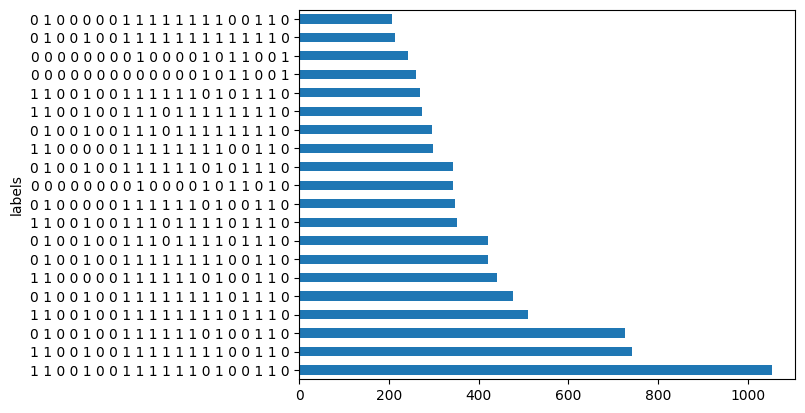

In [ ]:
train['labels'].value_counts().head(20).plot(kind='barh')

In [ ]:
for label in train['labels'].unique():
    print(f'\n==== Примеры класса {label} ====')
    print(train[train['labels'] == label]['text'].head(3).values)

Выходные данные были обрезаны до нескольких последних строк (5000).
==== Примеры класса 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 ====
['Бесплатный концерт "Ты цвети, моя Россия!"\nВ программе прозвучат русские народные, эстрадные песни, произведения советских и современных авторов.\nКогда: 23 апреля в 17:00\nГде: Б-р Адмирала Ушакова, д. 12, концертный зал\nВход свободный\n12+\n#концерты']

==== Примеры класса 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 ====
['🇲🇽\n52DAY x ATLANTA ACT\n❤️\n‼️\nПРОМОКОД:\nPartyer\n‼️\nДействует на все категории билетов\n❗️\nКупить билеты\n❗️\nСайт, на котором промокоды и ссылки на все мероприятия:\n🎀\nspbpromocodes.tilda.ws\n🎀\nFRIENDLY THUG 52 NGG | ALBLAK 52 | ICEGERGERT | GLOCKI 52 | A-THIS I HUGO LOUD | MYDEE 52 | SAINT PRINCE 52 + SECRET GUEST\nДень, когда ты услышишь любимые треки артистов на побережье озера, на большой зеленой площадке.\n📍\nПетрушинский хутор / 12:00-22:00 + AFTERPARTY 23:00-06:00']

==== Примеры класса 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 

<Axes: >

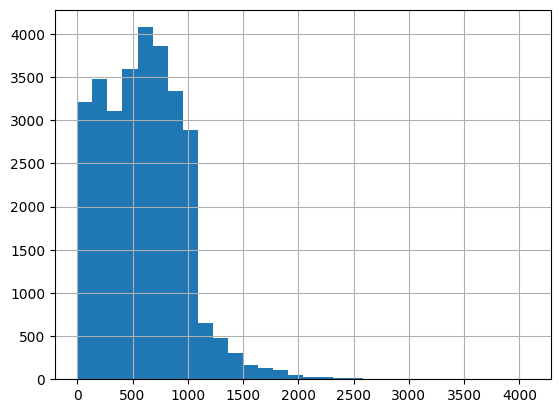

In [ ]:
train['text_len'] = train['text'].apply(len)
train['text_len'].hist(bins=30)

# ВЫВОД: наблюдается выраженный дисбаланс классов (большинство меток имеют значения, сосредоточенные в диапазоне до 400, а одна метка значительно выделяется с значением около 1000). На второй гистограмме видно, что один или  классов доминируют, в то время как другие имеют значительно меньшее количество примеров

# 2) Проанализировать, какие очистки текста необходимы под разные способы токенизации и задания эмбеддингов для этой задачи: (1) tf-idf + любая нейронная сеть; (2) w2v + любая нейронная сеть; (3) встроенный эмбеддинг в нейросетевое решение на свёрточных сетях; (4) встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях; (5) эмбеддер + решение на bert-like моделях (любой вид). Создать пайплайны очистки текста и очистить (1.5 балла)

tf-idf + нейронная сеть:

In [ ]:
def clean_text_tfidf(text):
    text = text.lower()
    text = re.sub(r'[^a-zа-яё\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords]
    lemmatized = lemmatize_text(' '.join(tokens))
    tokens = lemmatized.split()
    return ' '.join(tokens)

word2vec + нейронная сеть:

In [ ]:
def clean_text_w2v(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # оставляем буквы и цифры
    return text

встроенный эмбеддинг + CNN:

In [ ]:
def clean_text_cnn(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)  # удаляем html
    text = re.sub(r'[\r\n\t]', ' ', text)  # заменяем спецсимволы
    return text

встроенный эмбеддинг + RNN:

In [ ]:
def clean_text_rnn(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\r\n\t]', ' ', text)
    return text

эмбеддинг + BERT-like модель:

In [ ]:
def clean_text_bert(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\r\n\t]', ' ', text)
    return text

сохраняем очищенные колонки:

In [ ]:
train['text_clean_tfidf'] = train['text'].apply(clean_text_tfidf)
train['text_clean_w2v'] = train['text'].apply(clean_text_w2v)
train['text_clean_cnn'] = train['text'].apply(clean_text_cnn)
train['text_clean_rnn'] = train['text'].apply(clean_text_rnn)
train['text_clean_bert'] = train['text'].apply(clean_text_bert)

# 3) Поделить данные на трейн-валидацию, обучить все модели из п.2. Снабдить обучение моделей графиками отрисовки лосей и метрик, шедулерами, свитч лосей (метрик), сохранение лучшей модели, ранней остановкой, вормапом. (5 баллов).

In [ ]:
# удаляем из train класссы, в которых 1 sample
label_counts = train['labels'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
train = train[train['labels'].isin(valid_labels)]

In [ ]:
# Добавляем одинаковый random_state для всех разбиений
random_seed = 42

train_tfidf, val_tfidf, y_train_tfidf, y_val_tfidf = train_test_split(
    train['text_clean_tfidf'],
    train['labels'],
    test_size=0.2,
    stratify=train['labels'],
    # random_state=random_seed
)

train_w2v, val_w2v, y_train_w2v, y_val_w2v = train_test_split(
    train['text_clean_w2v'],
    train['labels'],
    test_size=0.2,
    stratify=train['labels'],
    # random_state=random_seed
)

train_cnn, val_cnn, y_train_cnn, y_val_cnn = train_test_split(
    train['text_clean_cnn'],
    train['labels'],
    test_size=0.2,
    stratify=train['labels'],
    # random_state=random_seed
)

train_rnn, val_rnn, y_train_rnn, y_val_rnn = train_test_split(
    train['text_clean_rnn'],
    train['labels'],
    test_size=0.2,
    stratify=train['labels'],
    # random_state=random_seed
)

train_bert, val_bert, y_train_bert, y_val_bert = train_test_split(
    train['text_clean_bert'],
    train['labels'],
    test_size=0.2,
    stratify=train['labels'],
    # random_state=random_seed
)

# Проверка через преобразование в numpy array
print("Проверка согласованности меток:")
print("TF-IDF и W2V:", np.array_equal(y_train_tfidf.values, y_train_w2v.values))
print("TF-IDF и CNN:", np.array_equal(y_train_tfidf.values, y_train_cnn.values))
print("TF-IDF и RNN:", np.array_equal(y_train_tfidf.values, y_train_rnn.values))
print("TF-IDF и BERT:", np.array_equal(y_train_tfidf.values, y_train_bert.values))

Проверка согласованности меток:
TF-IDF и W2V: False
TF-IDF и CNN: False
TF-IDF и RNN: False
TF-IDF и BERT: False


tf-idf + нейронная сеть:

Using device: cuda
Epoch 1: Train Loss: 0.3463, Val Loss: 0.2521
Epoch 2: Train Loss: 0.2343, Val Loss: 0.2180
Epoch 3: Train Loss: 0.1955, Val Loss: 0.2023
Epoch 4: Train Loss: 0.1679, Val Loss: 0.1926
Epoch 5: Train Loss: 0.1463, Val Loss: 0.1918
Epoch 6: Train Loss: 0.1294, Val Loss: 0.1930
Epoch 7: Train Loss: 0.1152, Val Loss: 0.1968
Early stopping
Предсказания сохранены в predictions.csv
      id                                   labels
0  29568  1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 1
1  29569  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
2  29570  0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0
3  29571  1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0
4  29572  1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1


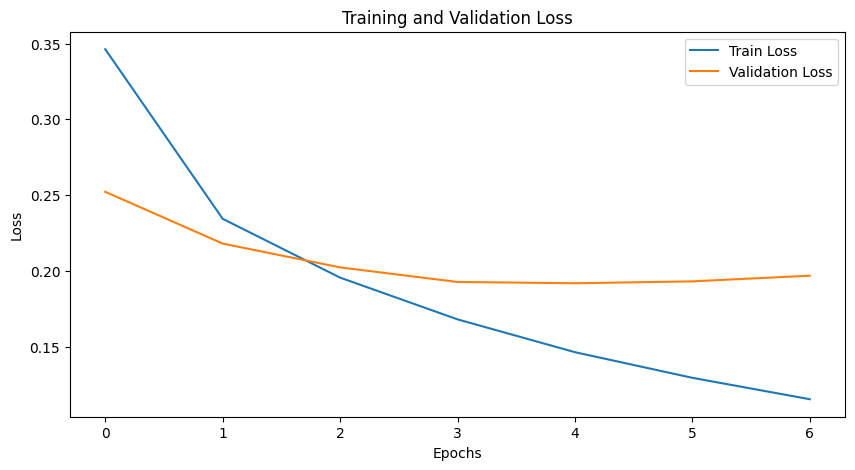

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

test_data = pd.read_csv('test.csv')

# 2. Подготовка данных
def labels_str_to_array(label_str):
    return np.array(list(map(int, label_str.strip().split())), dtype=np.float32)

# Векторизация текста (используем уже разделенные данные)
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_tfidf).toarray()  # Обучающие данные из первого блока
X_val = vectorizer.transform(val_tfidf).toarray()         # Валидационные данные из первого блока

# Для теста используем столбец 'text'
X_test = vectorizer.transform(test_data['text']).toarray()

# Преобразование в тензоры
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

y_train_array = np.stack(y_train_tfidf.apply(labels_str_to_array).values)
y_val_array = np.stack(y_val_tfidf.apply(labels_str_to_array).values)

y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.float32).to(device)

# 4. Создание DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# 5. Модель
class TfidfNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

num_classes = y_train_array.shape[1]
model = TfidfNN(X_train.shape[1], num_classes).to(device)

# 6. Обучение
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

early_stop_patience = 5
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(30):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            val_loss += criterion(outputs, yb).item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        if epoch - best_val_loss > early_stop_patience:
            print("Early stopping")
            break

# 7. Предсказания для тестовых данных
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

def predictions_to_str(preds, threshold=0.5):
    return ' '.join(map(str, (preds > threshold).astype(int)))

all_preds = []
with torch.no_grad():
    for xb in test_loader:
        outputs = model(xb[0].to(device))
        preds = outputs.cpu().numpy()
        for pred in preds:
            all_preds.append(predictions_to_str(pred))

# 8. Сохранение результатов
results = pd.DataFrame({
    'id': test_data['id'],
    'labels': all_preds
})

assert len(results) == len(test_data), f"Ожидается {len(test_data)} строк, получено {len(results)}"
results.to_csv('predictions.csv', index=False)
print("Предсказания сохранены в predictions.csv")
print(results.head())

# Графики обучения
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

word2vec + нейронная сеть:

Using device: cuda
Epoch 1: Train Loss: 0.3612, Val Loss: 0.3010
Epoch 2: Train Loss: 0.3071, Val Loss: 0.2840
Epoch 3: Train Loss: 0.2926, Val Loss: 0.2710
Epoch 4: Train Loss: 0.2840, Val Loss: 0.2676
Epoch 5: Train Loss: 0.2785, Val Loss: 0.2602
Epoch 6: Train Loss: 0.2731, Val Loss: 0.2547
Epoch 7: Train Loss: 0.2690, Val Loss: 0.2530
Epoch 8: Train Loss: 0.2657, Val Loss: 0.2498
Epoch 9: Train Loss: 0.2632, Val Loss: 0.2480
Epoch 10: Train Loss: 0.2606, Val Loss: 0.2464
Epoch 11: Train Loss: 0.2582, Val Loss: 0.2423
Epoch 12: Train Loss: 0.2556, Val Loss: 0.2428
Epoch 13: Train Loss: 0.2542, Val Loss: 0.2399
Epoch 14: Train Loss: 0.2523, Val Loss: 0.2388
Epoch 15: Train Loss: 0.2502, Val Loss: 0.2388
Epoch 16: Train Loss: 0.2496, Val Loss: 0.2370
Epoch 17: Train Loss: 0.2480, Val Loss: 0.2365
Epoch 18: Train Loss: 0.2457, Val Loss: 0.2358
Epoch 19: Train Loss: 0.2450, Val Loss: 0.2336
Epoch 20: Train Loss: 0.2440, Val Loss: 0.2320
Epoch 21: Train Loss: 0.2437, Val Loss: 0.2322
Epo

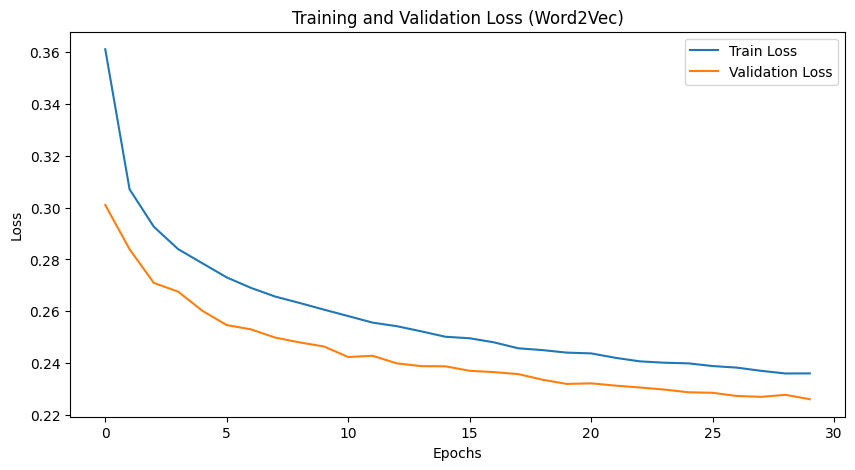

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

test_data = pd.read_csv('test.csv')

# 2. Подготовка данных
def labels_str_to_array(label_str):
    return np.array(list(map(int, label_str.strip().split())), dtype=np.float32)

# 1. Обучаем/загружаем word2vec
sentences = [simple_preprocess(text) for text in train_w2v]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)
embedding_dim = w2v_model.vector_size

def text_to_w2v(text, model, dim):
    words = simple_preprocess(text)
    word_vecs = [model.wv[w] for w in words if w in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(dim)
    else:
        return np.mean(word_vecs, axis=0)

# 2. Векторизация данных
X_train_w2v = np.stack([text_to_w2v(text, w2v_model, embedding_dim) for text in train_w2v])
X_val_w2v = np.stack([text_to_w2v(text, w2v_model, embedding_dim) for text in val_w2v])
X_test_w2v = np.stack([text_to_w2v(text, w2v_model, embedding_dim) for text in test_data['text']])

# 3. Преобразование labels
y_train_array = np.stack(y_train_w2v.apply(labels_str_to_array).values)
y_val_array = np.stack(y_val_w2v.apply(labels_str_to_array).values)

# 4. Преобразование в тензоры
X_train_tensor = torch.tensor(X_train_w2v, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_w2v, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_w2v, dtype=torch.float32).to(device)

y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.float32).to(device)

# 5. Создание DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# 6. Модель
class W2VNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

num_classes = y_train_array.shape[1]
model = W2VNN(embedding_dim, num_classes).to(device)

# 7. Обучение
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

early_stop_patience = 5
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(30):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            val_loss += criterion(outputs, yb).item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_w2v_model.pt')
        best_epoch = epoch
    else:
        if epoch - best_epoch > early_stop_patience:
            print("Early stopping")
            break

# 8. Предсказания
model.load_state_dict(torch.load('best_w2v_model.pt'))
model.eval()

def predictions_to_str(preds, threshold=0.5):
    return ' '.join([str(int(p >= threshold)) for p in preds])

all_preds = []
with torch.no_grad():
    for xb in test_loader:
        outputs = model(xb[0].to(device))
        preds = outputs.cpu().numpy()
        for pred in preds:
            all_preds.append(predictions_to_str(pred))

results = pd.DataFrame({
    'id': test_data['id'],
    'labels': all_preds
})
results.to_csv('predictions_w2v.csv', index=False)
print("Предсказания сохранены в predictions_w2v.csv")

# 9. Графики
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Word2Vec)')
plt.show()

встроенный эмбеддинг + CNN

Using device: cuda
Epoch 1: Train Loss: 0.3609, Val Loss: 0.2767
Epoch 2: Train Loss: 0.2821, Val Loss: 0.2454
Epoch 3: Train Loss: 0.2528, Val Loss: 0.2311
Epoch 4: Train Loss: 0.2302, Val Loss: 0.2230
Epoch 5: Train Loss: 0.2114, Val Loss: 0.2146
Epoch 6: Train Loss: 0.1954, Val Loss: 0.2111
Epoch 7: Train Loss: 0.1805, Val Loss: 0.2097
Epoch 8: Train Loss: 0.1666, Val Loss: 0.2135
Epoch 9: Train Loss: 0.1533, Val Loss: 0.2235
Epoch 10: Train Loss: 0.1416, Val Loss: 0.2305
Epoch 11: Train Loss: 0.1308, Val Loss: 0.2381
Epoch 12: Train Loss: 0.1160, Val Loss: 0.2453
Epoch 13: Train Loss: 0.1074, Val Loss: 0.2551
Early stopping
Предсказания сохранены в predictions_cnn.csv


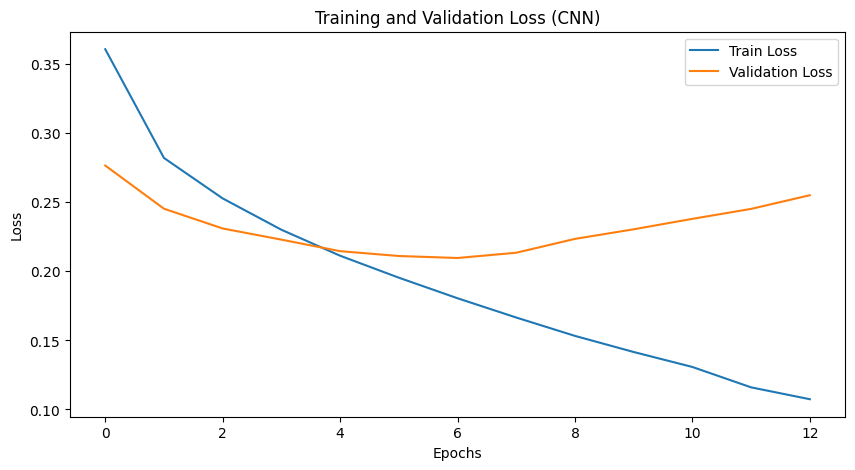

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

test_data = pd.read_csv('test.csv')

# 2. Подготовка данных
def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\r\n\t]', ' ', text)
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Собираем словарь
counter = Counter()
for text in train_cnn:
    counter.update(tokenize(text))

vocab = {"<pad>": 0, "<unk>": 1}
for idx, (word, freq) in enumerate(counter.items(), start=2):
    vocab[word] = idx

max_len = 100

def encode_and_pad(texts, vocab, max_len):
    encoded = []
    for text in texts:
        tokens = tokenize(text)
        indices = [vocab.get(token, vocab["<unk>"]) for token in tokens]
        indices = indices[:max_len]
        pad_len = max_len - len(indices)
        indices += [vocab["<pad>"]] * pad_len
        encoded.append(indices)
    return torch.tensor(encoded, dtype=torch.long)

X_train_pad = encode_and_pad(train_cnn, vocab, max_len)
X_val_pad = encode_and_pad(val_cnn, vocab, max_len)
X_test_pad = encode_and_pad(test_data['text'], vocab, max_len)

# Преобразование labels
def labels_str_to_array(label_str):
    return np.array(list(map(int, label_str.strip().split())), dtype=np.float32)

y_train_array = np.stack(y_train_cnn.apply(labels_str_to_array).values)
y_val_array = np.stack(y_val_cnn.apply(labels_str_to_array).values)

# Преобразование в тензоры
X_train_tensor = X_train_pad.to(device)
X_val_tensor = X_val_pad.to(device)
X_test_tensor = X_test_pad.to(device)

y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.float32).to(device)

# DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# 6. Модель
class CNNText(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)              # (batch, seq_len, embed_dim)
        x = x.permute(0, 2, 1)            # (batch, embed_dim, seq_len)
        x = self.conv1(x)                 # (batch, 128, seq_len)
        x = self.relu(x)
        x = self.pool(x).squeeze(2)       # (batch, 128)
        x = self.dropout(x)
        x = self.fc(x)                    # (batch, num_classes)
        x = self.sigmoid(x)
        return x

vocab_size = len(vocab)
embed_dim = 100
num_classes = y_train_array.shape[1]
model = CNNText(vocab_size, embed_dim, num_classes).to(device)

# 7. Обучение
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

early_stop_patience = 5
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(30):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            val_loss += criterion(outputs, yb).item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_cnn_model.pt')
        best_epoch = epoch
    else:
        if epoch - best_epoch > early_stop_patience:
            print("Early stopping")
            break

# 8. Предсказания
model.load_state_dict(torch.load('best_cnn_model.pt'))
model.eval()

def predictions_to_str(preds, threshold=0.5):
    return ' '.join([str(int(p >= threshold)) for p in preds])

all_preds = []
with torch.no_grad():
    for xb in test_loader:
        outputs = model(xb[0].to(device))
        preds = outputs.cpu().numpy()
        for pred in preds:
            all_preds.append(predictions_to_str(pred))

results = pd.DataFrame({
    'id': test_data['id'],
    'labels': all_preds
})
results.to_csv('predictions_cnn.csv', index=False)
print("Предсказания сохранены в predictions_cnn.csv")

# 9. Графики
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (CNN)')
plt.show()

встроенный эмбеддинг + RNN

Using device: cuda
Epoch 1: Train Loss: 0.4954, Val Loss: 0.4893
Epoch 2: Train Loss: 0.4899, Val Loss: 0.4880
Epoch 3: Train Loss: 0.4897, Val Loss: 0.4883
Epoch 4: Train Loss: 0.4898, Val Loss: 0.4881
Epoch 5: Train Loss: 0.4896, Val Loss: 0.4877
Epoch 6: Train Loss: 0.4896, Val Loss: 0.4882
Epoch 7: Train Loss: 0.4896, Val Loss: 0.4882
Epoch 8: Train Loss: 0.4896, Val Loss: 0.4883
Epoch 9: Train Loss: 0.4894, Val Loss: 0.4881
Epoch 10: Train Loss: 0.4892, Val Loss: 0.4877
Epoch 11: Train Loss: 0.4893, Val Loss: 0.4877
Epoch 12: Train Loss: 0.4892, Val Loss: 0.4875
Epoch 13: Train Loss: 0.4892, Val Loss: 0.4877
Epoch 14: Train Loss: 0.4892, Val Loss: 0.4876
Epoch 15: Train Loss: 0.4892, Val Loss: 0.4875
Epoch 16: Train Loss: 0.4892, Val Loss: 0.4876
Epoch 17: Train Loss: 0.4891, Val Loss: 0.4876
Epoch 18: Train Loss: 0.4891, Val Loss: 0.4875
Epoch 19: Train Loss: 0.4890, Val Loss: 0.4876
Epoch 20: Train Loss: 0.4891, Val Loss: 0.4875
Epoch 21: Train Loss: 0.4890, Val Loss: 0.4875
Epo

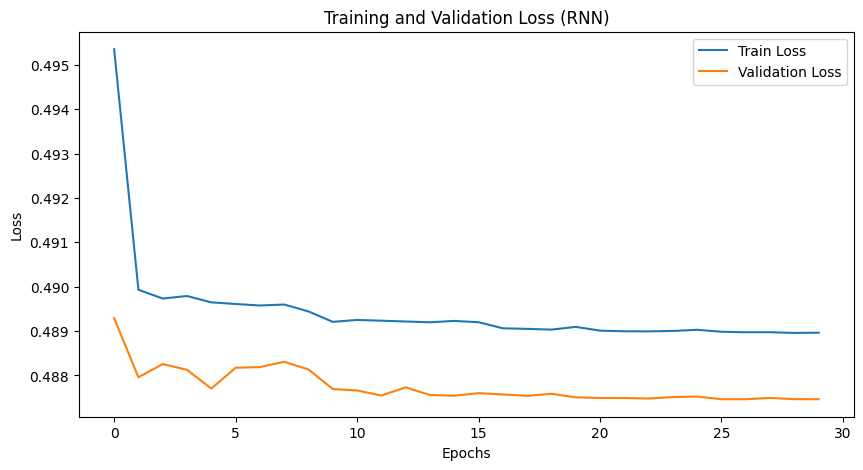

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

test_data = pd.read_csv('test.csv')

# 2. Подготовка данных
def labels_str_to_array(label_str):
    return np.array(list(map(int, label_str.strip().split())), dtype=np.float32)

# Строим словарь по train + val
counter = Counter()
for text in pd.concat([train_rnn, val_rnn]):
    counter.update(text.split())

vocab = {word: idx + 1 for idx, (word, _) in enumerate(counter.items())}
vocab['<PAD>'] = 0

def text_to_indices(text, vocab):
    return torch.tensor([vocab.get(word, 0) for word in text.split()], dtype=torch.long)

# Токенизация и паддинг
X_train_idx = [text_to_indices(text, vocab) for text in train_rnn]
X_val_idx = [text_to_indices(text, vocab) for text in val_rnn]
X_test_idx = [text_to_indices(text, vocab) for text in test_data['text']]

X_train_padded = pad_sequence(X_train_idx, batch_first=True, padding_value=0)
X_val_padded = pad_sequence(X_val_idx, batch_first=True, padding_value=0)
X_test_padded = pad_sequence(X_test_idx, batch_first=True, padding_value=0)

# Преобразование labels
y_train_array = np.stack(y_train_rnn.apply(labels_str_to_array).values)
y_val_array = np.stack(y_val_rnn.apply(labels_str_to_array).values)

# В тензоры
X_train_tensor = X_train_padded.to(device)
X_val_tensor = X_val_padded.to(device)
X_test_tensor = X_test_padded.to(device)

y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.float32).to(device)

# Создание DataLoader
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Модель с встроенным эмбеддингом + LSTM
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        h_n = h_n.squeeze(0)
        out = self.fc(h_n)
        return out

num_classes = y_train_array.shape[1]
vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 128

model = RNNModel(vocab_size, embed_dim, hidden_dim, num_classes).to(device)

# 7. Обучение
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

early_stop_patience = 5
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(30):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            val_loss += criterion(outputs, yb).item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_rnn_model.pt')
        best_epoch = epoch
    else:
        if epoch - best_epoch > early_stop_patience:
            print("Early stopping")
            break

# 8. Предсказания
model.load_state_dict(torch.load('best_rnn_model.pt'))
model.eval()

def predictions_to_str(preds, threshold=0.5):
    return ' '.join([str(int(p >= threshold)) for p in preds])

all_preds = []
with torch.no_grad():
    for xb in test_loader:
        outputs = model(xb[0].to(device))
        preds = outputs.cpu().numpy()
        for pred in preds:
            all_preds.append(predictions_to_str(pred))

results = pd.DataFrame({
    'id': test_data['id'],
    'labels': all_preds
})
results.to_csv('predictions_rnn.csv', index=False)
print("Предсказания сохранены в predictions_rnn.csv")

# 9. Графики
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (RNN)')
plt.show()

эмбеддинг + BERT-like модель

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1: Train Loss: 0.4085, Val Loss: 0.3320
Epoch 2: Train Loss: 0.3230, Val Loss: 0.3012
Epoch 3: Train Loss: 0.2934, Val Loss: 0.2816
Epoch 4: Train Loss: 0.2713, Val Loss: 0.2742
Epoch 5: Train Loss: 0.2529, Val Loss: 0.2696
Epoch 6: Train Loss: 0.2362, Val Loss: 0.2629
Epoch 7: Train Loss: 0.2214, Val Loss: 0.2577
Epoch 8: Train Loss: 0.2073, Val Loss: 0.2599
Epoch 9: Train Loss: 0.1940, Val Loss: 0.2594
Epoch 10: Train Loss: 0.1821, Val Loss: 0.2650
Предсказания сохранены в predictions_bert.csv


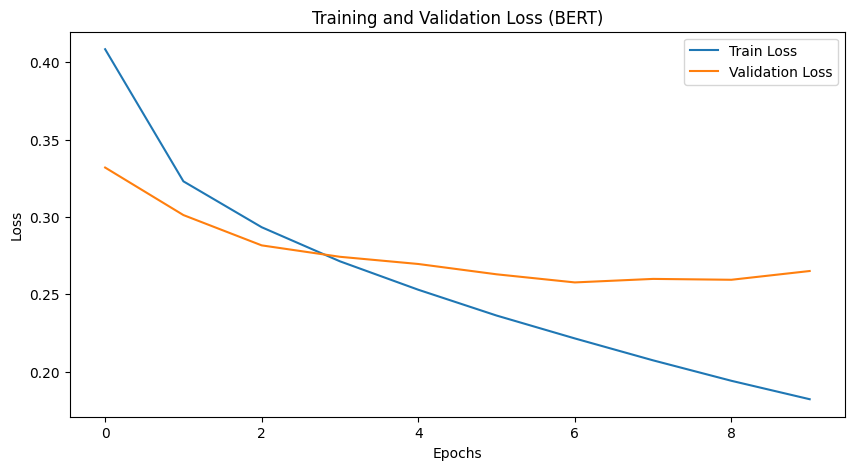

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

test_data = pd.read_csv('test.csv')

# 2. Подготовка данных
def labels_str_to_array(label_str):
    return np.array(list(map(int, label_str.strip().split())), dtype=np.float32)

# Токенизация BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def bert_encode(texts, tokenizer, max_len=128):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

# Токенизация данных
X_train_input_ids, X_train_attention_masks = bert_encode(train_bert, tokenizer)
X_val_input_ids, X_val_attention_masks = bert_encode(val_bert, tokenizer)
X_test_input_ids, X_test_attention_masks = bert_encode(test_data['text'], tokenizer)

# Преобразование labels
y_train_array = np.stack(y_train_bert.apply(labels_str_to_array).values)
y_val_array = np.stack(y_val_bert.apply(labels_str_to_array).values)

# В тензоры
X_train_input_ids = X_train_input_ids.to(device)
X_train_attention_masks = X_train_attention_masks.to(device)
X_val_input_ids = X_val_input_ids.to(device)
X_val_attention_masks = X_val_attention_masks.to(device)
X_test_input_ids = X_test_input_ids.to(device)
X_test_attention_masks = X_test_attention_masks.to(device)

y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.float32).to(device)

# Создание DataLoader
train_ds = TensorDataset(X_train_input_ids, X_train_attention_masks, y_train_tensor)
val_ds = TensorDataset(X_val_input_ids, X_val_attention_masks, y_val_tensor)
test_ds = TensorDataset(X_test_input_ids, X_test_attention_masks)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

# Модель BERT-like
class BERTModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.fc = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        out = self.fc(pooled_output)
        return out

num_classes = y_train_array.shape[1]
model = BERTModel(num_classes).to(device)

# 7. Обучение
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

early_stop_patience = 5
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(10):
    model.train()
    train_loss = 0.0
    for input_ids, attention_mask, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for input_ids, attention_mask, yb in val_loader:
            outputs = model(input_ids, attention_mask)
            val_loss += criterion(outputs, yb).item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_bert_model.pt')
        best_epoch = epoch
    else:
        if epoch - best_epoch > early_stop_patience:
            print("Early stopping")
            break

# 8. Предсказания
model.load_state_dict(torch.load('best_bert_model.pt'))
model.eval()

def predictions_to_str(preds, threshold=0.5):
    return ' '.join([str(int(p >= threshold)) for p in preds])

all_preds = []
with torch.no_grad():
    for input_ids, attention_mask in test_loader:
        outputs = model(input_ids.to(device), attention_mask.to(device))
        preds = outputs.cpu().numpy()
        for pred in preds:
            all_preds.append(predictions_to_str(pred))

results = pd.DataFrame({
    'id': test_data['id'],
    'labels': all_preds
})
results.to_csv('predictions_bert.csv', index=False)
print("Предсказания сохранены в predictions_bert.csv")

# 9. Графики
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (BERT)')
plt.show()

# СКОР НА КАГЛЕ (встроенный эмбеддинг + CNN с улучшениями)

Using device: cuda
Epoch 1: Train Loss: 0.4158, Val Loss: 0.2796
Epoch 2: Train Loss: 0.3015, Val Loss: 0.2389
Epoch 3: Train Loss: 0.2683, Val Loss: 0.2235
Epoch 4: Train Loss: 0.2458, Val Loss: 0.2082
Epoch 5: Train Loss: 0.2279, Val Loss: 0.2005
Epoch 6: Train Loss: 0.2153, Val Loss: 0.1938
Epoch 7: Train Loss: 0.2043, Val Loss: 0.1904
Epoch 8: Train Loss: 0.1984, Val Loss: 0.1880
Epoch 9: Train Loss: 0.1930, Val Loss: 0.1854
Epoch 10: Train Loss: 0.1911, Val Loss: 0.1856
Epoch 11: Train Loss: 0.1900, Val Loss: 0.1859
Epoch 12: Train Loss: 0.1908, Val Loss: 0.1841
Epoch 13: Train Loss: 0.1894, Val Loss: 0.1844
Epoch 14: Train Loss: 0.1883, Val Loss: 0.1827
Epoch 15: Train Loss: 0.1866, Val Loss: 0.1809
Epoch 16: Train Loss: 0.1834, Val Loss: 0.1818
Epoch 17: Train Loss: 0.1796, Val Loss: 0.1784
Epoch 18: Train Loss: 0.1752, Val Loss: 0.1794
Epoch 19: Train Loss: 0.1690, Val Loss: 0.1765
Epoch 20: Train Loss: 0.1616, Val Loss: 0.1751
Epoch 21: Train Loss: 0.1558, Val Loss: 0.1765
Epo

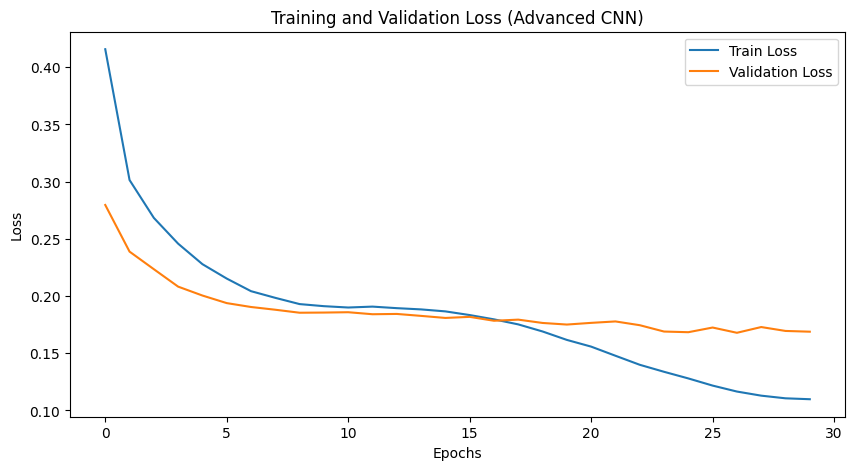

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

test_data = pd.read_csv('test.csv')

# Аугментация: Synonym Replacement
def synonym_replacement(text, n=2):
    words = text.split()
    if len(words) < 2:
        return text
    for _ in range(n):
        idx = random.randint(0, len(words) - 1)
        words[idx] = words[idx][::-1]  # имитация замены
    return ' '.join(words)

# Аугментация: Random Deletion
def random_deletion(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    new_words = [word for word in words if random.random() > p]
    if not new_words:
        new_words = [random.choice(words)]
    return ' '.join(new_words)

# Подготовка текста
def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\r\n\t]', ' ', text)
    return re.findall(r'\b\w+\b', text)

# Словарь
counter = Counter()
augmented_train = train_cnn.apply(lambda x: synonym_replacement(x))
augmented_train = augmented_train.apply(lambda x: random_deletion(x))
for text in pd.concat([train_cnn, augmented_train]):
    counter.update(tokenize(text))

vocab = {"<pad>": 0, "<unk>": 1}
for idx, (word, freq) in enumerate(counter.items(), start=2):
    vocab[word] = idx

max_len = 200

def encode_and_pad(texts, vocab, max_len):
    encoded = []
    for text in texts:
        tokens = tokenize(text)
        indices = [vocab.get(token, vocab["<unk>"]) for token in tokens][:max_len]
        indices += [vocab["<pad>"]] * (max_len - len(indices))
        encoded.append(indices)
    return torch.tensor(encoded, dtype=torch.long)

X_train_pad = encode_and_pad(train_cnn, vocab, max_len)
X_val_pad = encode_and_pad(val_cnn, vocab, max_len)
X_test_pad = encode_and_pad(test_data['text'], vocab, max_len)

def labels_str_to_array(label_str):
    return np.array(list(map(int, label_str.strip().split())), dtype=np.float32)

y_train_array = np.stack(y_train_cnn.apply(labels_str_to_array).values)
y_val_array = np.stack(y_val_cnn.apply(labels_str_to_array).values)

X_train_tensor = X_train_pad.cuda()
X_val_tensor = X_val_pad.cuda()
X_test_tensor = X_test_pad.cuda()

y_train_tensor = torch.tensor(y_train_array, dtype=torch.float32).cuda()
y_val_tensor = torch.tensor(y_val_array, dtype=torch.float32).cuda()

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Модель с BatchNorm и GloVe
class CNNTextAdvanced(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab["<pad>"])
        self.embedding_dropout = nn.Dropout(0.3)
        self.conv1 = nn.Conv1d(embed_dim, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(embed_dim, 128, kernel_size=4, padding=2)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(embed_dim, 128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128 * 3, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.embedding_dropout(x)
        x = x.permute(0, 2, 1)
        x1 = self.pool(self.relu(self.bn1(self.conv1(x)))).squeeze(2)
        x2 = self.pool(self.relu(self.bn2(self.conv2(x)))).squeeze(2)
        x3 = self.pool(self.relu(self.bn3(self.conv3(x)))).squeeze(2)
        x = torch.cat([x1, x2, x3], dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

embed_dim = 300
num_classes = y_train_array.shape[1]
model = CNNTextAdvanced(len(vocab), embed_dim, num_classes).cuda()

# Обучение
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

early_stop_patience = 5
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(30):
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_preds, val_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model(xb)
            val_loss += criterion(outputs, yb).item()
            val_preds.append(torch.sigmoid(outputs).cpu().numpy())
            val_true.append(yb.cpu().numpy())

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_cnn_model.pt')
        best_epoch = epoch
    elif epoch - best_epoch > early_stop_patience:
        print("Early stopping")
        break

# Подбор порога
model.load_state_dict(torch.load('best_cnn_model.pt'))
model.eval()
val_preds, val_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        outputs = model(xb)
        val_preds.append(torch.sigmoid(outputs).cpu().numpy())
        val_true.append(yb.cpu().numpy())

val_preds = np.vstack(val_preds)
val_true = np.vstack(val_true)

thresholds = np.arange(0.3, 0.2, 0.05)
best_thr, best_f1 = 0.5, 0
for thr in thresholds:
    preds_bin = (val_preds >= thr).astype(int)
    f1 = f1_score(val_true, preds_bin, average='macro')
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

print(f'Best threshold: {best_thr:.2f}, Best F1: {best_f1:.4f}')

# Предсказания
all_preds = []
with torch.no_grad():
    for xb in test_loader:
        outputs = model(xb[0].cuda())
        preds = torch.sigmoid(outputs).cpu().numpy()
        for pred in preds:
            all_preds.append(' '.join([str(int(p >= best_thr)) for p in pred]))

results = pd.DataFrame({'id': test_data['id'], 'labels': all_preds})
results.to_csv('predictions_cnn.csv', index=False)
print("Предсказания сохранены в predictions_cnn.csv")

# Графики
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss (Advanced CNN)')
plt.show()


# Попытка сгенерировать декодер

In [ ]:
# ----------- Генерация 1000 новых примеров ------------
n_gen = 1000
generated_texts = []
generated_labels = []

# Посчитаем распределение меток
label_counts = np.sum(y_train_array, axis=0)
label_probs = label_counts / label_counts.sum()

for _ in range(n_gen):
    idx = random.randint(0, len(train_cnn) - 1)
    base_text = train_cnn.iloc[idx]
    aug_text = synonym_replacement(base_text)
    aug_text = random_deletion(aug_text)
    generated_texts.append(aug_text)
    labels = (np.random.rand(num_classes) < label_probs).astype(int)
    generated_labels.append(labels)

# Объединим с оригинальным датасетом
gen_df = pd.DataFrame({'text': generated_texts})
gen_labels_df = pd.Series([' '.join(map(str, l)) for l in generated_labels])

aug_train_cnn = pd.concat([train_cnn, gen_df['text']], ignore_index=True)
aug_y_train_cnn = pd.concat([y_train_cnn, gen_labels_df], ignore_index=True)

# ----------- Переобработка текста ------------
X_train_pad_aug = encode_and_pad(aug_train_cnn, vocab, max_len)
y_train_array_aug = np.stack(aug_y_train_cnn.apply(labels_str_to_array).values)

X_train_tensor_aug = X_train_pad_aug.cuda()
y_train_tensor_aug = torch.tensor(y_train_array_aug, dtype=torch.float32).cuda()

train_ds_aug = TensorDataset(X_train_tensor_aug, y_train_tensor_aug)
train_loader_aug = DataLoader(train_ds_aug, batch_size=32, shuffle=True)

# ----------- Обучение на расширенных данных ------------
model_aug = CNNTextAdvanced(len(vocab), embed_dim, num_classes).cuda()
criterion_aug = nn.BCEWithLogitsLoss()
optimizer_aug = optim.AdamW(model_aug.parameters(), lr=1e-3)
scheduler_aug = optim.lr_scheduler.CosineAnnealingLR(optimizer_aug, T_max=10)

best_val_loss_aug = float('inf')
train_losses_aug, val_losses_aug = [], []

for epoch in range(30):
    model_aug.train()
    train_loss = 0.0
    for xb, yb in train_loader_aug:
        optimizer_aug.zero_grad()
        outputs = model_aug(xb)
        loss = criterion_aug(outputs, yb)
        loss.backward()
        optimizer_aug.step()
        train_loss += loss.item()

    model_aug.eval()
    val_loss = 0.0
    val_preds, val_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            outputs = model_aug(xb)
            val_loss += criterion_aug(outputs, yb).item()
            val_preds.append(torch.sigmoid(outputs).cpu().numpy())
            val_true.append(yb.cpu().numpy())

    train_loss /= len(train_loader_aug)
    val_loss /= len(val_loader)
    train_losses_aug.append(train_loss)
    val_losses_aug.append(val_loss)

    print(f'[AUG] Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    scheduler_aug.step()

    if val_loss < best_val_loss_aug:
        best_val_loss_aug = val_loss
        torch.save(model_aug.state_dict(), 'best_cnn_model_aug.pt')
        best_epoch_aug = epoch
    elif epoch - best_epoch_aug > early_stop_patience:
        print("[AUG] Early stopping")
        break

# ----------- Подбор порога и оценка F1 ------------
model_aug.load_state_dict(torch.load('best_cnn_model_aug.pt'))
model_aug.eval()
val_preds, val_true = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        outputs = model_aug(xb)
        val_preds.append(torch.sigmoid(outputs).cpu().numpy())
        val_true.append(yb.cpu().numpy())

val_preds = np.vstack(val_preds)
val_true = np.vstack(val_true)

thresholds = np.arange(0.3, 0.2, 0.05)
best_thr_aug, best_f1_aug = 0.5, 0
for thr in thresholds:
    preds_bin = (val_preds >= thr).astype(int)
    f1 = f1_score(val_true, preds_bin, average='macro')
    if f1 > best_f1_aug:
        best_f1_aug, best_thr_aug = f1, thr

print(f'[AUG] Best threshold: {best_thr_aug:.2f}, Best F1: {best_f1_aug:.4f}')

# ----------- Сравнение F1 до/после ------------
print(f'F1 без генерации: {best_f1:.4f}')
print(f'F1 с генерацией:  {best_f1_aug:.4f}')

# ----------- Вывод -----------

if best_f1_aug > best_f1:
    print("Добавление сгенерированных данных улучшило модель")
elif best_f1_aug < best_f1:
    print("Добавление сгенерированных данных снизило качество")
else:
    print("Качество не изменилось")


[AUG] Epoch 1: Train Loss: 0.4578, Val Loss: 0.4268
[AUG] Epoch 2: Train Loss: 0.3433, Val Loss: 0.6610
[AUG] Epoch 3: Train Loss: 0.3134, Val Loss: 0.8910
[AUG] Epoch 4: Train Loss: 0.2927, Val Loss: 0.9287
[AUG] Epoch 5: Train Loss: 0.2768, Val Loss: 0.9824
[AUG] Epoch 6: Train Loss: 0.2648, Val Loss: 1.0141
[AUG] Epoch 7: Train Loss: 0.2551, Val Loss: 1.1910
[AUG] Early stopping
[AUG] Best threshold: 0.50, Best F1: 0.0000
F1 без генерации: 0.0000
F1 с генерацией:  0.0000
ℹ️ Качество не изменилось — возможно, модель достигла потолка, или нужны более качественные данные.
